In [3]:
# Import Libraries:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import time


## Modelo de movimento diferencial com dois motores e codificadores rotacionais

Para conduzir um robô de rastreio ('tracking robot') com dois motores (um motor à esquerda e outro à direita), controlamos a velocidade de cada roda para definir a trajetória do robô no plano $ (x, y) $. Neste tipo de robôs diferenciais, o movimento é determinado pela diferença de velocidade entre as rodas esquerda e direita.

### Modelação do Movimento do Robô no Plano (x, y) 

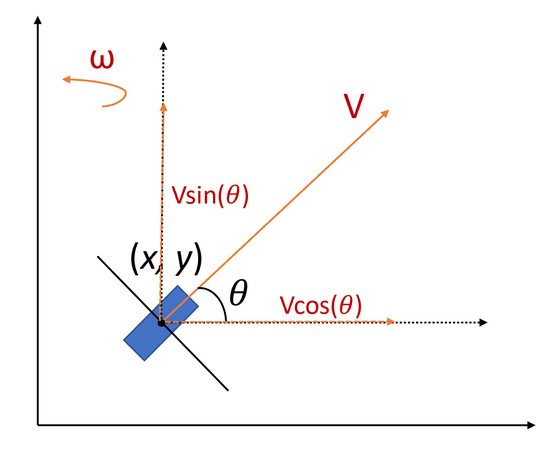

Suponhamos que:
- $ v_L $ é a velocidade linear da roda esquerda,
- $ v_R $ é a velocidade linear da roda direita,
- $ R $ é o raio da roda,
- $ d $ é a distância entre as rodas esquerda e direita (a base do robô).

### Velocidade Linear e Rotacional do Robô

A velocidade linear $v$ do robô (no centro do eixo entre as rodas) e a velocidade angular $ \omega $ (rotações por segundo) em torno do centro do robô são dadas por:

$$
v = \frac{v_L + v_R}{2}
$$

$$
\omega = \frac{v_R - v_L}{d}
$$

### Equações de Movimento

Se o robô começa num ponto inicial $ (x_0, y_0) $ com uma orientação inicial $ \theta_0 $ (ângulo em relação ao eixo $ x $), a posição do robô no tempo $ t $ pode ser calculada integrando a velocidade e a rotação ao longo do tempo. As equações de movimento são:

$$
x(t) = x_0 + \int_0^t v \cos(\theta(\tau)) \, d\tau
$$

$$
y(t) = y_0 + \int_0^t v \sin(\theta(\tau)) \, d\tau
$$

$$
\theta(t) = \theta_0 + \int_0^t \omega \, d\tau
$$

### Implementação Discreta

Para uma implementação discreta (em intervalos de tempo $ \Delta t $), podemos aproximar estas integrais para atualizar o estado do robô em cada instante $ k $:

$$
x_{k+1} = x_k + v \cos(\theta_k) \Delta t
$$

$$
y_{k+1} = y_k + v \sin(\theta_k) \Delta t
$$

$$
\theta_{k+1} = \theta_k + \omega \Delta t
$$

### Planeamento do Movimento

Para conduzir o robô do ponto inicial ao ponto final, respeitando a orientação inicial e a orientação final desejada, podemos dividir o movimento em três etapas:

1. **Rotação Inicial**: Alinhar o robô na direção do ponto final.
2. **Translação**: Mover em linha reta até o ponto final.
3. **Rotação Final**: Ajustar a orientação para a orientação final desejada.

Suponhamos que:
- $ (x_0, y_0) $ e $ \theta_0 $ representam a posição e orientação iniciais do robô.
- $ (x_f, y_f) $ e $ \theta_f $ representam a posição e orientação finais desejadas do robô.
- A distância entre as rodas do robô é $ d $, e o controle é feito ajustando as velocidades angulares das rodas esquerda e direita.

#### Rotação Inicial

Primeiro, precisamos alinhar o robô na direção do ponto final $ (x_f, y_f) $.

1. **Cálculo do Ângulo de Direção**: Calcule o ângulo de orientação desejada, $ \theta_d $, entre o ponto inicial $ (x_0, y_0) $ e o ponto final $ (x_f, y_f) $:

   $$
   \theta_d = \arctan\left(\frac{y_f - y_0}{x_f - x_0}\right)
   $$

2. **Rotação até $ \theta_d $**: Ajuste a velocidade angular $ \omega $ do robô para alinhar a orientação atual $ \theta_0 $ com $ \theta_d $. A rotação pode ser feita definindo as velocidades das rodas esquerda e direita, $ v_L $ e $ v_R $, com sinais opostos:

   - Se $ \theta_0 < \theta_d $, rode o robô no sentido anti-horário.
   - Se $ \theta_0 > \theta_d $, rode o robô no sentido horário.

   A rotação é realizada com:
   
   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   onde $ v $ é a velocidade desejada, de modo a gerar uma velocidade angular constante $ \omega = \frac{2v}{d} $ até que o robô atinja $ \theta_d $.

#### Translação em Linha Reta até o Ponto Final

Uma vez alinhado na direção do ponto final, o robô pode mover-se em linha reta até o ponto $ (x_f, y_f) $.

1. **Distância até o Ponto Final**: Calcule a distância $ d_f $ entre a posição atual $ (x, y) $ e o ponto final $ (x_f, y_f) $:

   $$
   d_f = \sqrt{(x_f - x)^2 + (y_f - y)^2}
   $$

2. **Movimento em Linha Reta**: Mova o robô para frente com uma velocidade linear constante $ v $ até percorrer a distância $ d_f $. Durante este movimento, a velocidade angular deve ser zero para manter o robô na linha reta:

   $$
   v_L = v \quad \text{e} \quad v_R = v
   $$

   Continue o movimento até que a posição atual do robô atinja o ponto $ (x_f, y_f) $.

#### Rotação Final

Finalmente, o robô deve ajustar a sua orientação para o ângulo final desejado $ \theta_f $.

1. **Diferença de Orientação**: Calcule a diferença angular $ \Delta \theta $ entre a orientação atual $ \theta $ e a orientação final $ \theta_f $:

   $$
   \Delta \theta = \theta_f - \theta
   $$

2. **Rotação para $ \theta_f $**: Ajuste novamente as velocidades das rodas com sinais opostos para criar uma rotação até que a orientação atual coincida com $ \theta_f $.

   - Se $ \theta < \theta_f $, rode o robô no sentido anti-horário.
   - Se $ \theta > \theta_f $, rode o robô no sentido horário.

   A rotação final é realizada com:

   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   até que o ângulo do robô seja igual a $ \theta_f $.


# Condução ao longo de segmento linear

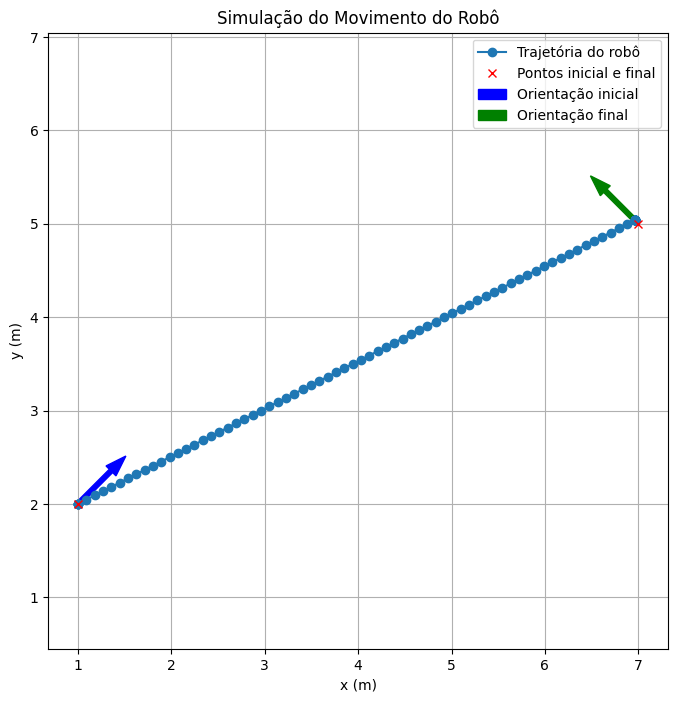

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do robô
v_linear = 1.0        # Velocidade linear (m/s)
v_angular = np.pi/4   # Velocidade angular (rad/s)

dt = 0.1              # Intervalo de tempo (s)

# Coordenadas e orientações iniciais e finais
x0, y0, theta0 = 1, 2, np.pi/4           # Ponto inicial e orientação inicial
xf, yf, thetaf = 7, 5, 3*np.pi/4         # Ponto final e orientação final

# Inicialização das variáveis
x, y, theta = x0, y0, theta0
trajectory_x = [x]
trajectory_y = [y]

# 1. Rotação inicial para alinhar o robô na direção do ponto final
theta_d = np.arctan2(yf - y0, xf - x0)
while abs(theta - theta_d) > 0.01:  # Até atingir a orientação desejada
    if theta < theta_d:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# 2. Translação em linha reta até o ponto final
distance = np.sqrt((xf - x)**2 + (yf - y)**2)
while distance > 0.1:  # Até atingir o ponto final
    x += v_linear * np.cos(theta) * dt
    y += v_linear * np.sin(theta) * dt
    distance = np.sqrt((xf - x)**2 + (yf - y)**2)
    trajectory_x.append(x)
    trajectory_y.append(y)

# 3. Rotação final para atingir a orientação final desejada
while abs(theta - thetaf) > 0.01:  # Até atingir a orientação final
    if theta < thetaf:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# Plot da trajetória
plt.figure(figsize=(8, 8))
plt.plot(trajectory_x, trajectory_y, '-o', label="Trajetória do robô")
plt.plot([x0, xf], [y0, yf], 'rx', label="Pontos inicial e final")
plt.arrow(x0, y0, 0.5 * np.cos(theta0), 0.5 * np.sin(theta0), color="blue", width=0.05, label="Orientação inicial")
plt.arrow(xf, yf, 0.5 * np.cos(thetaf), 0.5 * np.sin(thetaf), color="green", width=0.05, label="Orientação final")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.title("Simulação do Movimento do Robô")
plt.axis("equal")
plt.grid(True)
plt.show()


# Velocidade: linear, angular, esquerda, direita

## Medir velocidades com codificadores
Para incorporar as medições de velocidade usando os codificadores da roda esquerda e direita, precisamos entender que a velocidade de cada roda é determinada a partir das contagens dos codificadores em intervalos de tempo específicos. Cada codificador mede o número de "pulsos" ou "contagens" que ocorrem enquanto a roda gira, o que nos permite calcular a distância percorrida por cada roda e, portanto, a velocidade.

Vamos supor:
- $N_L$ e $N_R$ são as contagens de pulsos dos codificadores da roda esquerda e da roda direita, respetivamente, durante o intervalo de tempo $ \Delta t $.
- $P$ é o número de impulsos por rotação completo da roda (resolução do codificador).
- $R$ é o raio de cada roda.

Para o robot Zumo, o valor de $P$, o número de impulsos por rotação completo da roda (resolução do codificador), pode ser obtido da documentação online em: https://www.pololu.com/docs/0J63/3.4 $P = 900 CPR = 75 \cdot 12 CPR $ em que $CPR$ são as contagens por revolução do eixo, $75$ é o fator de redução da engrenagem mecânica entre o eixo da roda e o eixo do motor elétrico, e $12$ CPR as contagens de impulsos por rotação do eixo do motor. 

O raio da roda $R$ pode ser medido ou estimado da informação disponivel, é é o raio de cada roda.

Em alternativa, podem determinar em laboratório qual o incremento dos contadores para cada centímetro de movimento.

Seja qual o método de definir estes parâmetros, eles nunca serão 'perfeitos', ou seja, estarão associados a uma inverteza ou um 'erro' que deve ser mantida tão pequeno quanto possível, no entanto, nunca poderá ser eliminado. Como se vai ver adiante, esta incerteza introduz incerteza no control do movimento e estimação de velocidade e posição.

A distância percorrida por cada roda durante $ \Delta t $ pode ser obtida a partir da contagem de pulsos e da circunferência da roda ($ 2 \pi R $). Se $ N_L $ e $ N_R $ são as contagens de pulsos para a roda esquerda e direita, respetivamente, e $ \Delta N_L $ e $\Delta  N_R $ a variação das contagens desde a última medida, então a distância percorrida por cada roda ($ d_L $ para a roda esquerda e $ d_R $ para a direita) no intervalo de temp $dt$ é:

$$
\Delta d_L = \frac{\Delta N_L}{P} \cdot 2 \pi R
$$

$$
\Delta d_R = \frac{\Delta N_R}{P} \cdot 2 \pi R
$$

As velocidades lineares de cada roda, $ v_L $ e $ v_R $, são então dadas por:

$$
v_L = \frac{\Delta d_L}{\Delta t} = \frac{\Delta N_L}{P} \cdot \frac{2 \pi R}{\Delta t}
$$

$$
v_R = \frac{\Delta d_R}{\Delta t} = \frac{\Delta N_R}{P} \cdot \frac{2 \pi R}{\Delta t}
$$


## Calibrar as velocidades
À semelhança da calibração de velocidade'PWM vs RPM' dos motores e do aeropendulo,  será necessário calibrar o controlo direto da velocidade do robot.

No modelo mais simples de 'condução diferencial' do motor ('differential drive')  o movimento é controlado através do par de velocidades da roda da esquerda $v_L$ e da roda da direita $v_R$. Estes são controlados através de um sinal PWM ('Pulse width modulation') que está integrado através dos métodos de controlo de motor do Zumo. O sentido de rotação e o fator de ciclo são controlados através de um parâmetro adimensional, de $pwm_L$ e $pwm_R$ (número digital, valores inteiros, positivos ou negativos).
- $pwm_L$ e $pwm_R$ representam valores digitais, ou seja são múltiplos da unidade elementar de um 'bit' (binary digit). Em informática é boa prática usar o termo 'LSB', que significa 'Least Bignificant Bit', para explicitar o bit elementar, e associar ao número digital 'LSB' como unidade adimensional. 
-  De acordo com a informação na página do Zumo, e exemplos disponiveis no Arduino, temos:
 $$ -400 \, LSB < pwm_R <400 \, LSB$$
 $$ -400 \, LSB < pwm_L <400 \, LSB$$
- Começa se por assumir um modelo linear de ordem zero para a calibração
 $$ v_R=C_R \cdot pwm_R$$
 $$ v_L=C_L \cdot pwm_L$$
No entanto, é preciso ter cautela, uma vez que, como se viu por exemplo no caso da calibração do motor elétrico, a relação 'pwm vs rpm' não seguia esta relação. Nesse caso, não era a desprezar a dinâmica entre o sinal PWM e os seus tempos característicos, a interagir com os tempos caracteristicos, mecânicos e elétricos, do motor DC. Adicionalmente, o circuito do driver elétrico também poderá ter tido um papel. A lição aprendida foi que é preciso analisar com sentido crítico as medidas, e detrminar qual o modelo mais adequado para a curva de calibração. Esta questão só se coloca quando usar uma escala contínua de valores para $pwm_L$ e $pwm_R$. No caso de usar um valor de comando constante por partes, como por exemplo no controlo tipo 'bit-banging' ou seja, 'On-Off', é menos importante esta questão. No entanto, quando usar um controlo com variação contínua, por exemplo no controlo 'PID', é importante conhecer ben a variação da curva de calibração, incluindo as não idealidades e dinâmicas subjacentes.
 
Os coeficientes de calibração $C_R$ e $C_L$ (em unidade de cm/s/LSB) podem ser determinados através dos codificadores, através das equações anteriores:

$$v_R = \frac{2 \pi R}{P} \cdot \frac{\Delta N_R}{\Delta t}$$

$$v_L = \frac{2 \pi R}{P} \cdot \frac{\Delta N_L}{\Delta t}$$

em que $R \approx 2 \, cm$ é o raio das rodas e $P \approx 909 $ as contagens dos encoders por cada volta da roda.

Qual o erro associado aos valores assim obtidos de $v_R$ e $v_L$ ? Em geral, pela fórmula da propagação de erros:
$$ \frac{\Delta v_R}{v_R} = \sqrt{ \left ( \frac{\Delta R}{R} \right ) ^2 + \left ( \frac{\Delta P}{P} \right )^2 +\left ( \frac{\Delta N_R}{N_R} \right ) ^2+ \left ( \frac{\Delta (\Delta t)}{\Delta t} \right ) ^2 } $$ 

Para condições experimentais típicas, é seguro assumir que o erro dominante estará associado a determinação do raio da roda - inclusivamente pela possivel variabilidade das rodas. Assim, o erro é aproximadamente:
$$ \frac{\Delta v_R}{v_R} \approx \frac{\Delta R}{R} $$

Como exemplo: com um valor medido de $ R = (2.0 \pm 0.1 )\, cm$ o erro relativo passa a ser   $ \frac{\Delta v_R}{v_R} = 0.05 \approx 5\%$. Pode não parecer muito, no entanto, terá para sistemas em movimento um efeito cumulativo para a determinação da posição. Ou seja: a determinação da posição será ao longo do tempo cada vez mais incerta. 


Pelo modelo diferencial de condução temos para o robot em geral a velocidade linear $v$ e angular $\omega$

$$
v = \frac{v_R + v_L}{2}
$$

$$
\omega = \frac{v_R - v_L}{d}
$$

Métodos simples do tipo 'start-stop' são adequados para a calibração numa dimensão só, nos casos de translação pura $\omega=0$ ou rotação pura $v=0$. 

Por exemplo, é possivel calibrar a velocidade através de um sistema tipo 'start-stop': por exemplo uma pista linear com uma certa distância conhecida. E cronometrar o tempo de passagem.

 Na prática, na grande maioria de casos experimentais, a condição de comando $pwm_L + pwm_R = 0 $ não resulta em $v_R + v_L = 0$ nem $pwm_R - pwm_L = 0 $ resulta em não resulta em $v_R - v_L = 0$. 

De um modo geral é necessário calibrar em duas dimensões. As calibrações de $v$ e $\omega$ devem ser realizadas num referencial global ou seja, de laboratório, com algum método que permite analisar este movimento em duas dimensões, por exemplo equipar o robot com um símbolo gráfico tipo QR code, e colocar uma camera a detetar e analisar o movimento do robot. 